# GEODOS data processing

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime #, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [18]:
directory = "/storage/experiments/2021/0605_bourka_radosovice"
directory = "/storage/experiments/2021/0609_bourka_sobeslav"
directory = "/storage/experiments/2021/0713_bourka_exit29_D8"
directory = "/storage/experiments/2021/0714_bourka_sobeslav"
directory = "/storage/experiments/2021/0725_bourka_ratmirov"
directory = "/storage/experiments/2021/0726_bourka_zabori"
directory = "/storage/experiments/2021/0803_bourka_votice"
directory = "/storage/experiments/2021/0807_bourka_sobeslav"
directory = "/storage/experiments/2021/0815_bourka_veseli_auto1"
directory = "/storage/experiments/2021/0816_bourka_sobeslav"
directory = "/storage/experiments/2021/0822_bourka_sobeslav_auto1"
directory = "/storage/experiments/2021/0822_bourka_sobeslav_auto1"
directory = "/storage/experiments/2021/0830_bourka_kern"

directory = "/storage/experiments/2021/0725_bourka_ratmirov"
#directory = "/storage/experiments/2021/0803_bourka_votice"
directory = "/storage/experiments/2021/0807_bourka_sobeslav"

fto = directory + '/geodos/DATALOG.TXT'

l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

#!!!
#df.drop(df.index[:last[-1:][0]], inplace=True) # keep only last run

s.n.:  1290c00806a20091c057a000a0000036
f.v.:  51832f3
0    GEO2
Name: 1, dtype: object
1506
0


## Fill position and time by GPS NMEA records

In [19]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

if (len(df.loc[df[0]=='$GNRMC']) > 0):
    print('Warning - Multiconstellation appears')
    print('Use next cell.')
    raise StopExecution
#df.drop(df.loc[(df[0]=='$GPRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GPRMC',1]
df['gps_date'] = df.loc[df[0]=='$GPRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GPRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GPRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df


,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,alt,lat,lon,meas,UTC
4,$GPGSV,2,1,08,02,18,241,37,05,34,...,NaN,NaN,NaN,NaN,NaN,452.9,NaN,NaN,NaN,NaT
5,$GPGSV,2,2,08,13,20,276,45,14,34,...,NaN,NaN,NaN,NaN,NaN,452.9,NaN,NaN,NaN,NaT
11,$GPGSV,2,1,08,02,18,241,38,05,34,...,NaN,NaN,NaN,NaN,NaN,452.6,49.260781,14.691840,NaN,NaT
12,$GPGSV,2,2,08,13,20,276,45,14,34,...,NaN,NaN,NaN,NaN,NaN,452.6,49.260781,14.691840,NaN,NaT
14,$HIST,0,39.90,95321.00,24.56,3.51,722,160,891,1,...,NaN,NaN,NaN,NaN,NaN,452.6,49.260781,14.691840,0,2021-08-07 19:16:50.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,$GPGSV,4,4,15,26,10,032,34,28,07,...,NaN,NaN,NaN,NaN,NaN,485.8,49.260934,14.691773,419,2021-08-07 21:18:53.130
1933,$HIST,420,7387.72,95772.25,21.63,3.37,-35,325,891,0,...,NaN,NaN,NaN,NaN,NaN,479.5,49.260592,14.692063,420,2021-08-07 21:19:18.030
1934,$HITS,2,18932,23,145156,11,-35,325,891,0,...,NaN,NaN,NaN,NaN,NaN,479.5,49.260592,14.692063,420,2021-08-07 21:19:18.030
1935,$HIST,421,7403.50,95772.25,21.63,3.43,102,326,891,0,...,NaN,NaN,NaN,NaN,NaN,479.5,49.260592,14.692063,421,2021-08-07 21:19:33.810


## Fill position and time by NMEA records in case of multiconstellation support

In [422]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
# is valid GPS time?
df.loc[(df[0]=='$GPGSV'),'valid_gps_time'] = False
df.loc[(df[0]=='$GNRMC'),'valid_gps_time'] = True
df['valid_gps_time'] = df['valid_gps_time'].fillna(method='ffill')
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['valid_gps_time']==True),1]) * 1000

df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GNGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,496,497,498,499,alt,lat,lon,meas,UTC,valid_gps_time
14,$HIST,0,46.12,96171.00,28.31,3.81,-52,556,891,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaT,False
15,$HITS,4,85687,44,164719,9,166285,78,232381,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaT,False
16,$HIST,1,61.93,96236.50,28.31,3.81,-29,556,891,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,False
17,$HITS,3,51052,9,89843,14,197296,11,891,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaT,False
18,$HIST,2,77.97,96261.25,28.31,3.81,-21,556,891,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,$HITS,4,61998,57,163797,34,180580,10,226938,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292,NaT,False
1354,$HIST,293,5511.41,96141.00,22.75,3.78,-18,498,891,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293,NaT,False
1355,$HITS,3,70594,10,171945,22,193889,45,891,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293,NaT,False
1356,$HIST,294,5527.15,96143.25,22.75,3.78,-17,497,891,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294,NaT,False


## Add individual events to histogram

In [20]:
HISTHITS = 9 # Ratmirov
#HISTHITS = 28 # ABSjets
FIRSTCH = 2

df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:9+HISTHITS].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [21]:
hits.loc[hits[1]>500,1]=500
hits.loc[:,[*map('h{:04}'.format, range(1050))]] = 0
try:
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            hits.iloc[i,int(1042+hits.iloc[i,j*2+3])] +=1
except:
    print(i,j)
    raise
            
histogram = pd.DataFrame()
histogram = hist.iloc[:,9+FIRSTCH:9+HISTHITS]
histogram = histogram.join(hits.iloc[:,1042+HISTHITS:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram['lat'] = hist['lat']
histogram['lon'] = hist['lon']
histogram['UTC'] = hist['UTC']
histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:256],range(0,256))})
#histogram.to_csv(dto + '/histogram.csv')
histogram

,0,1,2,3,4,5,6,7,8,9,...,h1047,h1048,h1049,temperature,pressure,voltage,current,lat,lon,UTC
meas,,,,,,,,,,,,,,,,,,,,,
0,3.0,2,0.0,1.0,0.0,0.0,1.0,1,1,1,...,0,0,0,24.56,95321.00,3.51,722,49.260781,14.691840,2021-08-07 19:16:50.050
1,5.0,2,3.0,1.0,0.0,4.0,0.0,1,0,0,...,0,0,0,24.56,95320.00,3.52,751,49.260781,14.691840,2021-08-07 19:17:05.790
2,3.0,2,0.0,1.0,1.0,2.0,1.0,1,0,1,...,0,0,0,24.56,95320.50,3.52,765,49.260781,14.691840,2021-08-07 19:17:21.530
3,4.0,0,1.0,1.0,3.0,0.0,1.0,1,0,0,...,0,0,0,24.56,95324.50,3.52,774,49.260781,14.691840,2021-08-07 19:17:37.250
4,2.0,6,2.0,1.0,2.0,2.0,1.0,0,0,0,...,0,0,0,24.63,95325.75,3.52,782,49.260781,14.691840,2021-08-07 19:17:53.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,5.0,2,2.0,2.0,1.0,3.0,0.0,0,2,1,...,0,0,0,21.63,95772.25,3.37,-22,49.260934,14.691773,2021-08-07 21:18:21.610
418,6.0,5,0.0,1.0,0.0,3.0,4.0,0,2,1,...,0,0,0,21.69,95778.75,3.37,-20,49.260934,14.691773,2021-08-07 21:18:37.370
419,7.0,7,3.0,0.0,2.0,1.0,1.0,1,1,1,...,0,0,0,21.63,95775.75,3.37,-20,49.260934,14.691773,2021-08-07 21:18:53.130


In [22]:
events = pd.DataFrame(columns=['time', 'energy'])


try:
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            event_ch = hits.iloc[i,j*2+3]
            event_time = hits.iloc[i,j*2+2]
            etime = hist.iloc[i].UTC + pd.Timedelta(microseconds=64*event_time)
            events = events.append({'time':etime, 'energy':event_ch}, ignore_index=True)

except:
    print(i,j)
    raise
            
events.set_index('time', drop=False, inplace=True)
events.sort_index(inplace=True)

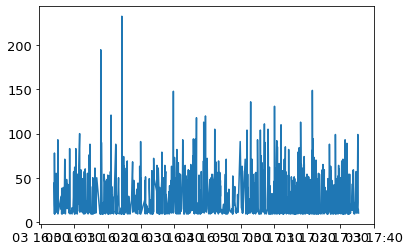

In [477]:
plt.plot(events.energy)

## Plot Flux

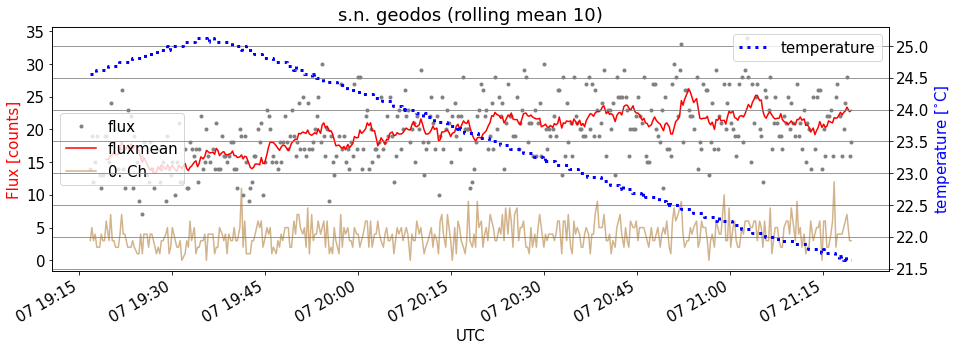

In [37]:
NOISE_LEVEL = 0
LAST_CHANNEL = 250
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2021-05-12 8:35:00':'2021-05-12 12:45:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



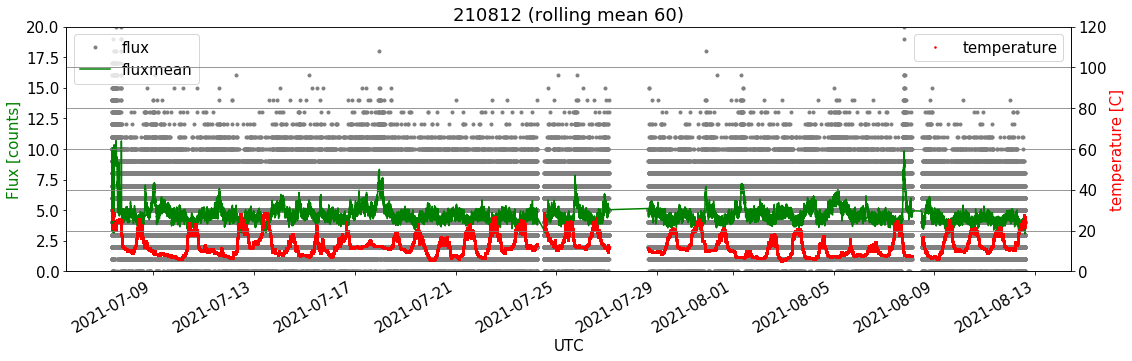

In [5]:
NOISE_LEVEL = 13
LAST_CHANNEL = 270
WINDOW = 60

plt.figure(figsize=(18,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-7 00:00:00':]
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 20:00:00']
#xx = xx.loc['2021-8-7 00:00:00':'2021-8-8 00:00:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='green')
#!!!(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([0,20])
#plt.xlim(['2021-7-7 00:00:00','2021-8-13 00:00:00'])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='green')
plt.legend(loc=2)

ax = plt.twinx()

xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid', zorder=1)
plt.ylabel('temperature [C]', color='red')
plt.ylim([0,120])

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



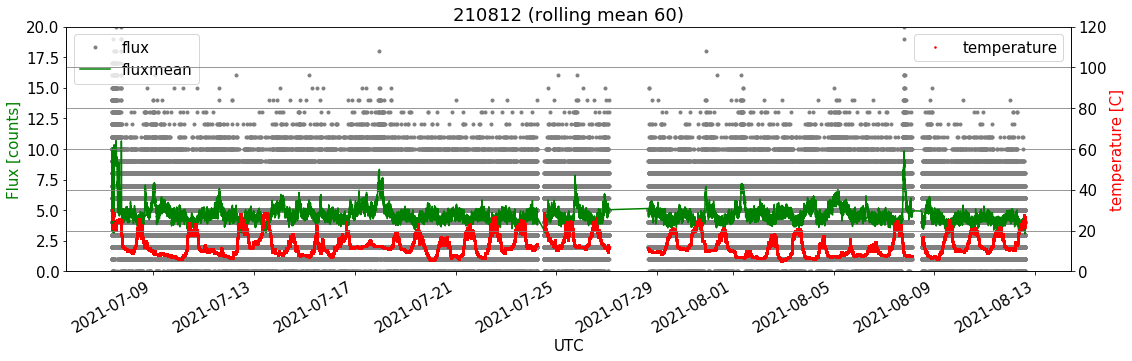

In [8]:
NOISE_LEVEL = 13
LAST_CHANNEL = 270
WINDOW = 60

plt.figure(figsize=(18,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-7 00:00:00':]
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 20:00:00']
#xx = xx.loc['2021-8-7 00:00:00':'2021-8-8 00:00:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='green')
#!!!(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([0,20])
#plt.xlim(['2021-7-7 00:00:00','2021-8-13 00:00:00'])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='green')
plt.legend(loc=2)

ax = plt.twinx()

xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid', zorder=1)
plt.ylabel('temperature [C]', color='red')
plt.ylim([0,120])

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



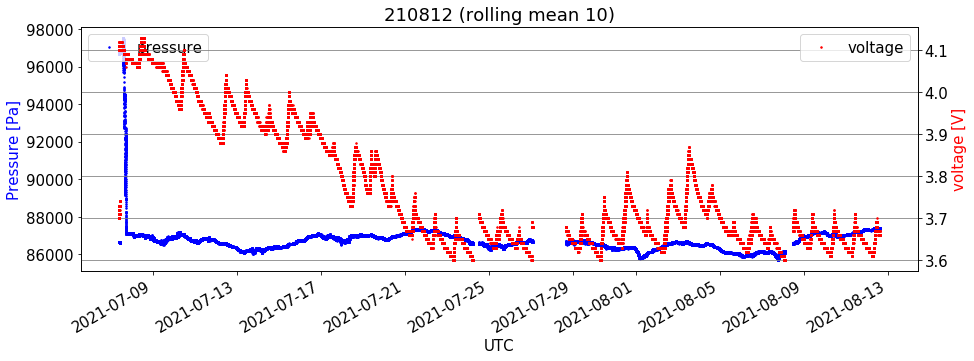

In [7]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[5].plot(c='red', label='voltage', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('voltage [V]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



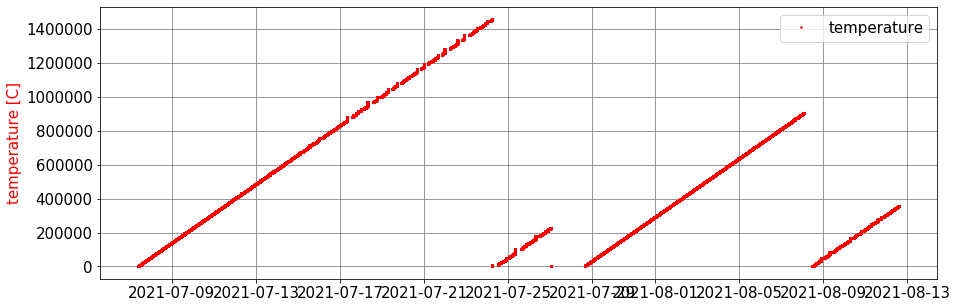

In [40]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']

#plt.ylim([0,14000])
plt.plot(xx.index, xx[2], c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


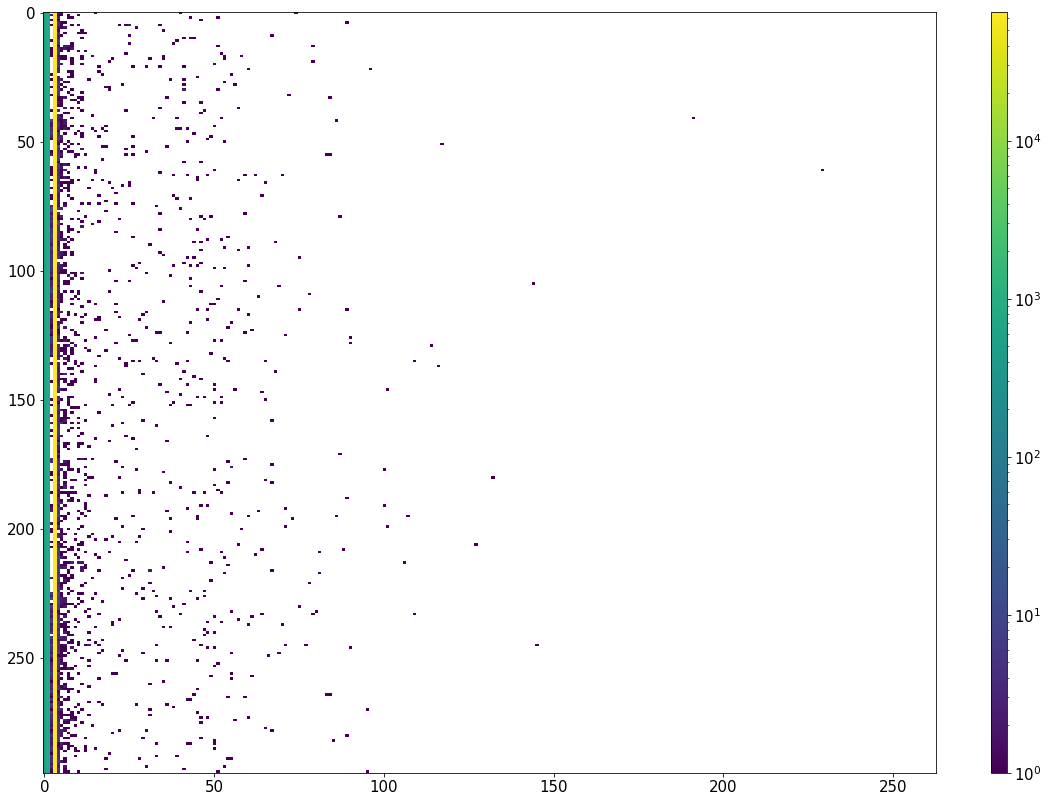

In [29]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((hist.iloc[:,7:270]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

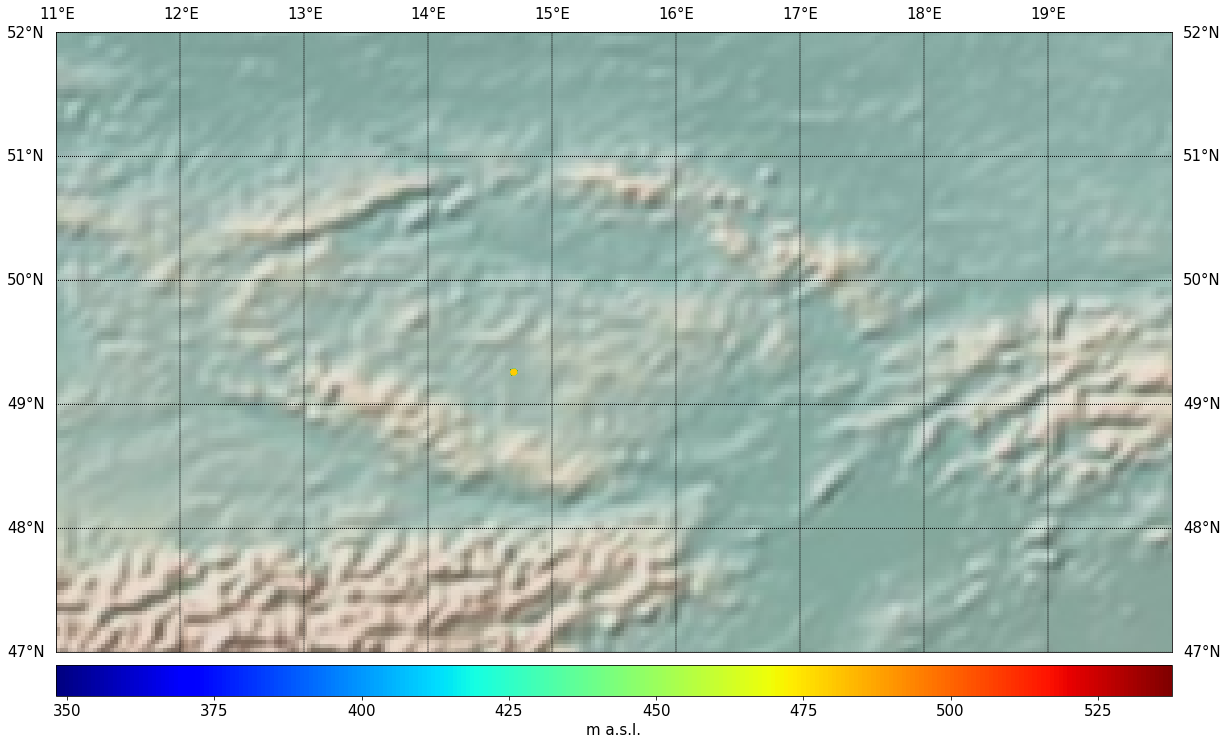

In [24]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(histogram.lon.tolist(),histogram.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,c=hist.alt.tolist(),marker='o', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


In [253]:
except
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

print(float(hist['lat'].tail(1)), " ", float(hist['lon'].tail(1)))
               
#m = Basemap(llcrnrlon=hist['lon'][-1:]-0.08,llcrnrlat=hist['lat'][-1:]-0.04,urcrnrlon=hist['lon'][-1:]+0.08, urcrnrlat=hist['lat'][-1:]+0.04,  epsg = 3395,resolution='i',projection='merc')
#m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
m.arcgisimage(service='ESRI_StreetMap_World_2D')


x, y = m(hist.lon.tolist(),hist.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])
#m.shadedrelief()

im1 = m.scatter(x,y,c=hist.alt.tolist(),marker='o', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


SyntaxError: invalid syntax (<ipython-input-253-c57f80dec4fd>, line 1)

In [254]:
except
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

print(float(hist['lat'].tail(1)), " ", float(hist['lon'].tail(1)))
print(float(hist['lat'][10]), " ", float(hist['lon'][10]))
               
m = Basemap(llcrnrlon=hist['lon'][10]-0.01,llcrnrlat=hist['lat'][10]-0.01,urcrnrlon=hist['lon'][10]+0.01, urcrnrlat=hist['lat'][10]+0.01,  epsg = 3395,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1000, verbose= True)

x, y = m(hist.lon.tolist(),hist.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])
#m.shadedrelief()

im1 = m.scatter(x,y,c=hist.alt.tolist(),marker='o', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


SyntaxError: invalid syntax (<ipython-input-254-533a950ac071>, line 1)

In [372]:
histogram.loc[pd.to_datetime(PARKING):].lat[0]

49.17479499999999

# Blitzortung

In [559]:
PARKING = '2021-8-3 16:45:00' # Votice
PARKING = '2021-8-15 20:00:00' # Veseli
PARKING = '' 
BLITZ_DIST = 200
if (PARKING == ''):
    lat = histogram.iloc[1].lat
    lon = histogram.iloc[1].lon
else:
    lat = histogram.loc[pd.to_datetime(PARKING):].lat[0]
    lon = histogram.loc[pd.to_datetime(PARKING):].lon[0]
region=1
start = histogram.iloc[0].UTC - pd.Timedelta(hours = 1)
end = histogram.iloc[0].UTC + pd.Timedelta(hours = 1)
print(start, end, lat, lon)

### url for json data preparation
url=[]
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-2) )&(blitz['lon']<(lon+2) )]
### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
#with pandas
blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
#blitz['time']=blitz.index    
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz.to_csv(directory + "/blitz.csv")
print('end')

2021-08-03 15:03:50.020000 2021-08-03 17:03:50.020000 49.26073616666666 14.6918025
end


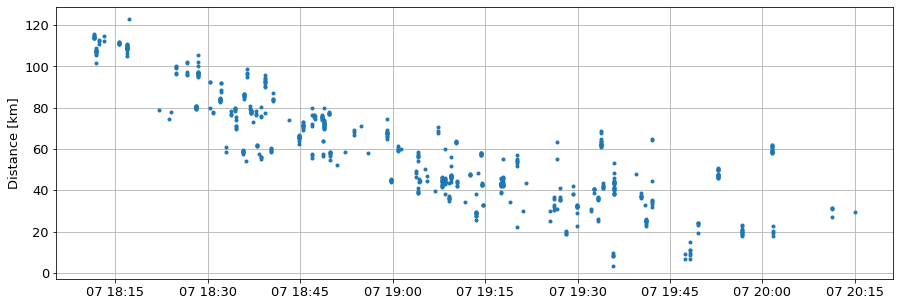

In [25]:
blitz = pd.read_csv(directory + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)
blitz.sort_index(inplace=True)

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 13})

blitz['date'] = pd.to_datetime(blitz.index, unit='ns')

plt.plot(blitz['date'], blitz['km'], ls='', marker='.')
#plt.ylim([0,40])
plt.ylabel('Distance [km]')
plt.grid()

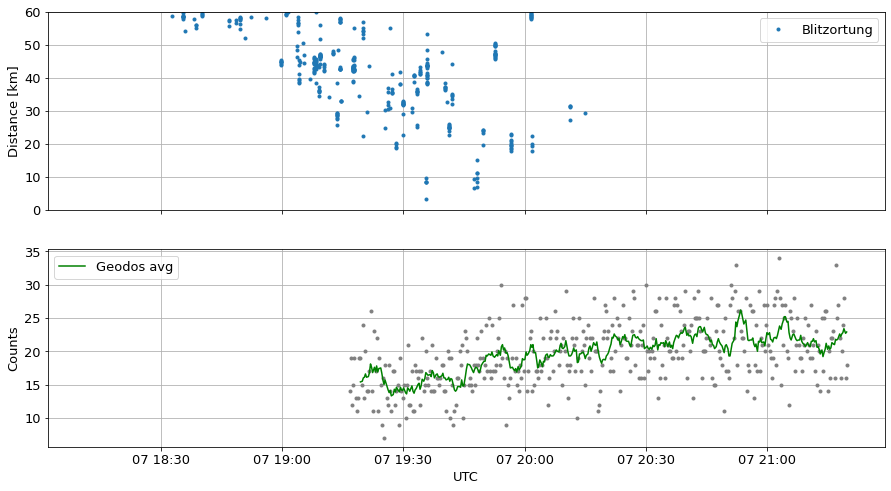

In [26]:
xx = histogram
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 14:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()


fig, (ax6, ax5) = plt.subplots(nrows=2, sharex=True, figsize=(15,8))

ax5.plot(xx['flux'], c='gray', linestyle='', marker='.')
ax5.plot(xx['fluxmean'], c='green', label='Geodos avg')
ax5.set_ylabel('Counts')
ax5.set_xlabel('UTC')
#ax5.set_ylim(0,21)
ax5.legend()
#ax5.set_yscale('log')
ax5.grid()

ax6.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,60)
ax6.legend()
ax6.grid()


In [27]:
NOISE_LEVEL = 12
LAST_CHANNEL = 270
WINDOW = 60

plt.figure(figsize=(18,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-7 00:00:00':]
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 20:00:00']
#xx = xx.loc['2021-8-7 00:00:00':'2021-8-8 00:00:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='green')
#!!!(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([2,20])
plt.xlim(['2021-7-13 00:00:00','2021-7-17 00:00:00'])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='green')
plt.legend(loc=2)

ax = plt.twinx()

plt.plot(blitz['date'], blitz['km'], ls='', marker='.',)
plt.ylim([-40,70])
plt.ylabel('Distance [km]')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



IndexError: positional indexers are out-of-bounds

<Figure size 1296x360 with 0 Axes>

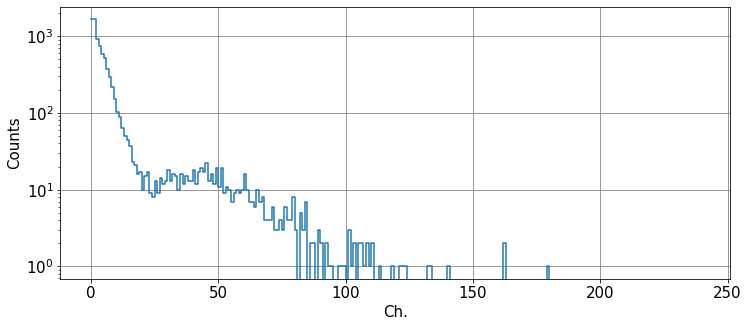

In [38]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-8-3 16:45:00':'2021-8-3 16:48:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#yy = yy.loc['2021-07-08 17:00:00':'2021-07-08 18:00:00']

#yy = yy.loc['2021-05-12 11:20:00':'2021-05-12 11:30:00']
#yy = yy.loc['2021-05-12 13:58:00':'2021-05-12 14:20:00']

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([0,30])

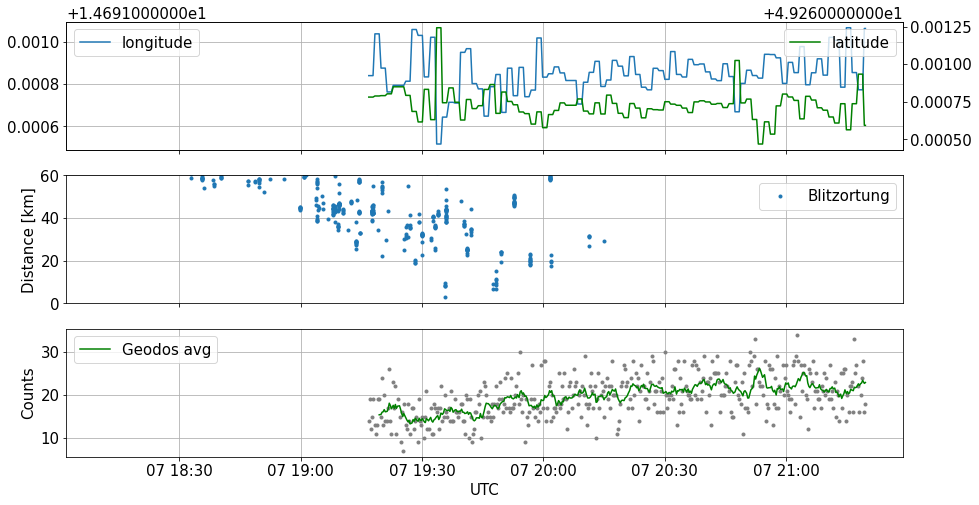

In [39]:
xx = histogram
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-25 14:00:00':'2021-7-26 14:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()


fig, (ax1, ax6, ax5) = plt.subplots(nrows=3, sharex=True, figsize=(15,8))
ax1_twin = ax1.twinx()

ax1.plot(xx['lon'], label='longitude')
ax1_twin.plot(xx['lat'], color='green', label='latitude')
ax1.grid()
ax1.legend(loc=2)
ax1_twin.legend(loc=1)

ax5.plot(xx['flux'], c='gray', linestyle='', marker='.')
ax5.plot(xx['fluxmean'], c='green', label='Geodos avg')
ax5.set_ylabel('Counts')
ax5.set_xlabel('UTC')
#ax5.set_ylim(0,21)
ax5.legend()
#ax5.set_yscale('log')
ax5.grid()

ax6.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,60)
ax6.legend()
ax6.grid()


## Timestamps

In [32]:
l=[]
l.extend(range(0,15))
gps = pd.read_table(directory + '/gps/timestamps.txt', sep=',', header=None, names=l)
gps = gps[gps[0]=='# TIM_TM2: ch=0']
gps['ToW'] = gps[4].str.extract(r'(\d+\.\d+|\d+)', expand=False).astype(int)
gps['R'] = gps[5].str.extract(r'(\d+\.\d+|\d+)', expand=False).astype(int)/1000
gps['F'] = gps[7].str.extract(r'(\d+\.\d+|\d+)', expand=False).astype(int)/1000
gps = gps.loc[gps[1].str.contains('241')]

In [34]:
def weeksecondstoutc(gpsweek,gpsseconds,leapseconds):
    import datetime, calendar
    datetimeformat = "%Y-%m-%d %H:%M:%S.%f"
    epoch = datetime.datetime.strptime("1980-01-06 00:00:00.000",datetimeformat)
    elapsed = datetime.timedelta(days=(gpsweek*7),seconds=(gpsseconds+leapseconds))
    return datetime.datetime.strftime(epoch + elapsed,datetimeformat)

gps['timeR'] = gps.apply(lambda x: weeksecondstoutc(int(x['ToW']), float(x['R']),0), axis=1)
gps['timeF'] = gps.apply(lambda x: weeksecondstoutc(int(x['ToW']), float(x['F']),0), axis=1)
gps['timeR'] = pd.to_datetime(gps['timeR'])
gps.set_index('timeR', inplace = True, drop=False)

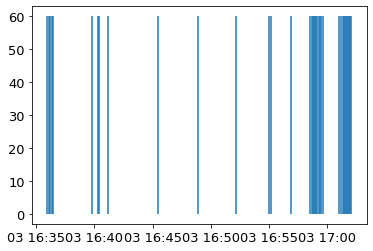

In [499]:
plt.vlines(x=gps['timeR'], ymin=0, ymax=60)
#plt.plot(gps['timeR'])

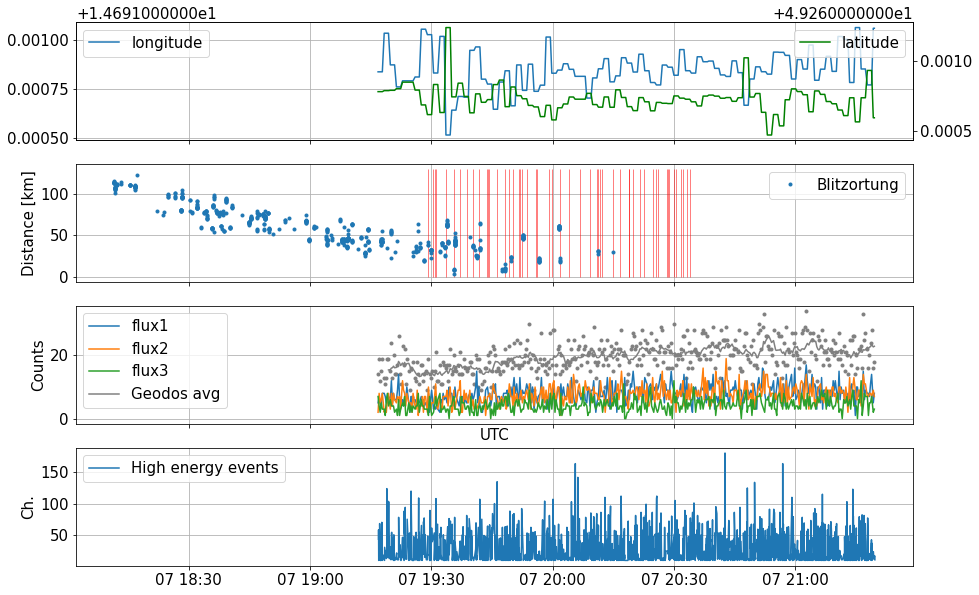

In [40]:
xx = histogram
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-25 17:45:00':'2021-7-25 19:00:00']
#blitz = blitz.loc['2021-7-25 18:00:00':'2021-7-25 18:20:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['flux1'] = (xx.iloc[:,range(NOISE_LEVEL,NOISE_LEVEL+2)].sum(axis=1))
xx['flux2'] = (xx.iloc[:,range(NOISE_LEVEL+2,NOISE_LEVEL+7)].sum(axis=1))
xx['flux3'] = (xx.iloc[:,range(NOISE_LEVEL+7,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()


fig, (ax1, ax6, ax5, ax2) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
ax1_twin = ax1.twinx()

ax1.plot(xx['lon'], label='longitude')
ax1_twin.plot(xx['lat'], color='green', label='latitude')
ax1.grid()
ax1.legend(loc=2)
ax1_twin.legend(loc=1)

ax5.plot(xx['flux'], c='gray', linestyle='', marker='.')
ax5.plot(xx['flux1'], label='flux1')
ax5.plot(xx['flux2'], label='flux2')
ax5.plot(xx['flux3'], label='flux3')
ax5.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5.set_ylabel('Counts')
ax5.set_xlabel('UTC')
#ax5.set_ylim(0,21)
ax5.legend()
#ax5.set_yscale('log')
ax5.grid()

ax6.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
#ax6.set_ylim(0,60)
ax6.legend()
ax6.grid()
ax6.vlines(x=gps['timeR'], ymin=0, ymax=130, color='red', label='trigger', lw=0.5)

ax2.plot(events.time, events.energy, label='High energy events')
ax2.set_ylabel('Ch.')
ax2.legend()
ax2.grid()



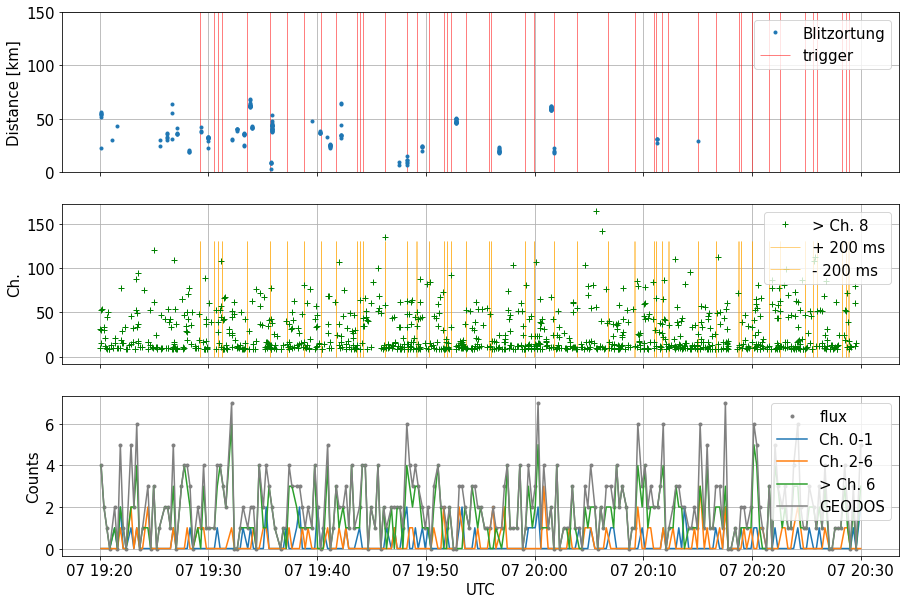

In [36]:
xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

# Votice
FROM = '2021-8-3 16:40:00' 
TO = '2021-8-3 16:59:00'
# Votice detail
FROM = '2021-8-3 16:48:30'
TO = '2021-8-3 16:49:10'
# Ratmirov
FROM = '2021-7-25 18:10:00'
TO = '2021-7-25 18:45:00'
# Sobeslav
FROM = '2021-8-7 19:20:00'
TO = '2021-8-7 20:30:00'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()
gps_x = gps.loc[pd.to_datetime(gps['timeR']) > pd.to_datetime(FROM)].loc[pd.to_datetime(gps['timeR'])<pd.to_datetime(TO)].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['flux1'] = (xx.iloc[:,range(NOISE_LEVEL,NOISE_LEVEL+2)].sum(axis=1))
xx['flux2'] = (xx.iloc[:,range(NOISE_LEVEL+2,NOISE_LEVEL+7)].sum(axis=1))
xx['flux3'] = (xx.iloc[:,range(NOISE_LEVEL+7,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()


fig, (ax6, ax2, ax5) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
#ax2_twin = ax2.twinx()

ax5.plot(xx['flux'], c='gray', linestyle='', marker='.', label='flux')
ax5.plot(xx['flux1'], label='Ch. 0-1')
ax5.plot(xx['flux2'], label='Ch. 2-6')
ax5.plot(xx['flux3'], label='> Ch. 6')
ax5.plot(xx['flux'], c='gray', label='GEODOS')
#ax5.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5.set_ylabel('Counts')
#ax5.set_ylim(0,21)
ax5.legend()
#ax5.set_yscale('log')
ax5.grid()
ax5.set_xlabel('UTC')

ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,150)
ax6.grid()
ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='trigger', lw=0.5)
ax6.legend()

ax2.plot(events_x.energy, ls='', marker='+', color='green', label='> Ch. 8')
ax2.set_ylabel('Ch.')
ax2.grid()
#ax2.vlines(x=gps_x['timeR'], ymin=0, ymax=130, color='red', label='trigger', lw=0.5)
ax2.vlines(x=gps_x['timeR'] + datetime.timedelta(milliseconds=200), ymin=0, ymax=130, color='orange', label='+ 200 ms', lw=0.5)
ax2.vlines(x=gps_x['timeR'] - datetime.timedelta(milliseconds=200), ymin=0, ymax=130, color='orange', label='- 200 ms', lw=0.5)
ax2.legend(loc=1)

#ax2_twin.plot(blitz.date, blitz.km, ls='', marker='2', markersize=10, label='Blitzortung')
#ax2_twin.set_ylabel('Distance [km]')
#ax2_twin.vlines(x=gps['timeR'], ymin=0, ymax=160, color='red', label='trigger', lw=0.5)
#ax2_twin.legend(loc=2)



Text(0.5, 1.0, '/storage/experiments/2021/0803_bourka_votice')

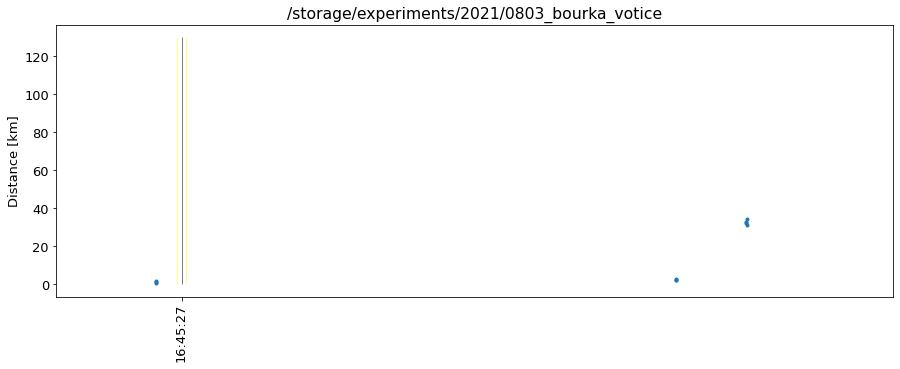

In [446]:
gps['timelabel'] = gps['timeR'].dt.strftime('%H:%M:%S')

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 13})

plt.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
plt.ylabel('Distance [km]')
#plt.legend()
#plt.grid()
plt.vlines(x=gps['timeR'] + datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'] - datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'], ymin=0, ymax=130, color='black', label='trigger', lw=0.5)
pyplot.xticks(gps['timeR'], gps['timelabel'], rotation='vertical')
#plt.xlim(pd.to_datetime('2021-8-7 19:30:00'),pd.to_datetime('2021-8-7 20:30:00')) # Votice
plt.xlim(pd.to_datetime('2021-8-3 16:45:00'),pd.to_datetime('2021-8-3 16:48:00')) # Votice TGE
#plt.xlim(pd.to_datetime('2021-8-15 19:45:00'),pd.to_datetime('2021-8-15 20:26:00')) # Veseli
#plt.xlim(pd.to_datetime('2021-7-25 18:10:00'),pd.to_datetime('2021-7-25 18:45:00')) # Ratmirov
plt.title(directory)

(18833.770833333332, 18833.781944444443)

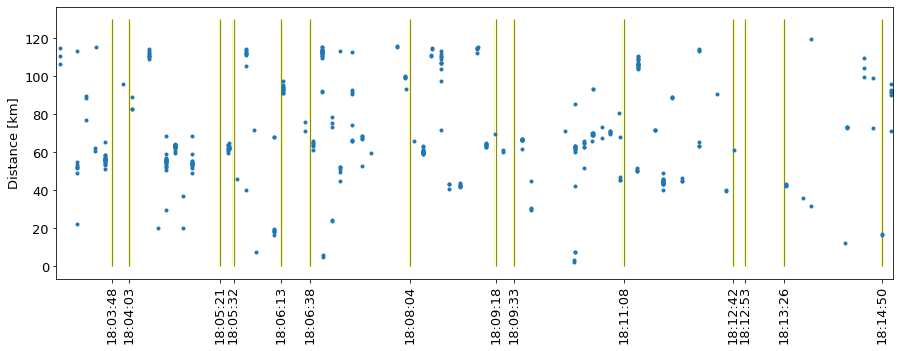

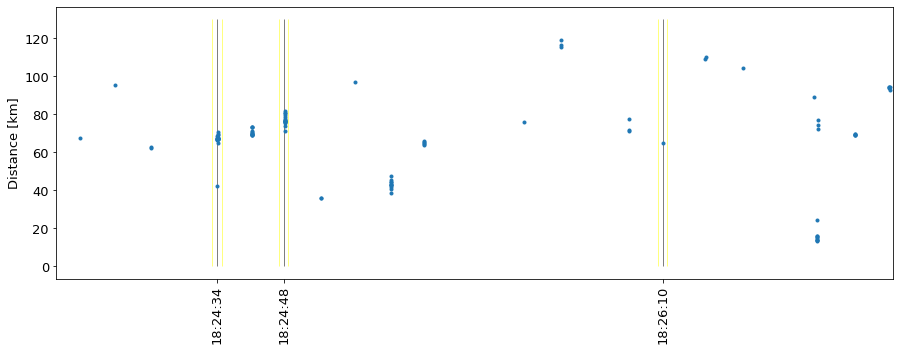

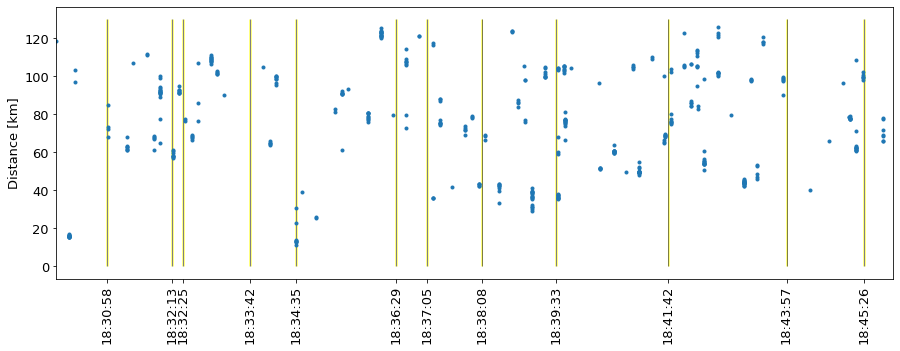

In [243]:
gps['timelabel'] = gps['timeR'].dt.strftime('%H:%M:%S')

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 13})

plt.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
plt.ylabel('Distance [km]')
#plt.legend()
#plt.grid()
plt.vlines(x=gps['timeR'] + datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'] - datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'], ymin=0, ymax=130, color='black', label='trigger', lw=0.5)
pyplot.xticks(gps['timeR'], gps['timelabel'], rotation='vertical')
plt.xlim(pd.to_datetime('2021-7-25 18:03:00'),pd.to_datetime('2021-7-25 18:15:00'))

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 13})

plt.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
plt.ylabel('Distance [km]')
#plt.legend()
#plt.grid()
plt.vlines(x=gps['timeR'] + datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'] - datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'], ymin=0, ymax=130, color='black', label='trigger', lw=0.5)
pyplot.xticks(gps['timeR'], gps['timelabel'], rotation='vertical')
#plt.xlim(pd.to_datetime('2021-7-25 18:15:00'),pd.to_datetime('2021-7-25 18:30:00'))
plt.xlim(pd.to_datetime('2021-7-25 18:24:00'),pd.to_datetime('2021-7-25 18:27:00'))

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 13})

plt.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
plt.ylabel('Distance [km]')
#plt.legend()
#plt.grid()
plt.vlines(x=gps['timeR'] + datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'] - datetime.timedelta(seconds=1), ymin=0, ymax=130, color='yellow', label='trigger', lw=0.5)
plt.vlines(x=gps['timeR'], ymin=0, ymax=130, color='black', label='trigger', lw=0.5)
pyplot.xticks(gps['timeR'], gps['timelabel'], rotation='vertical')
plt.xlim(pd.to_datetime('2021-7-25 18:30:00'),pd.to_datetime('2021-7-25 18:46:00'))

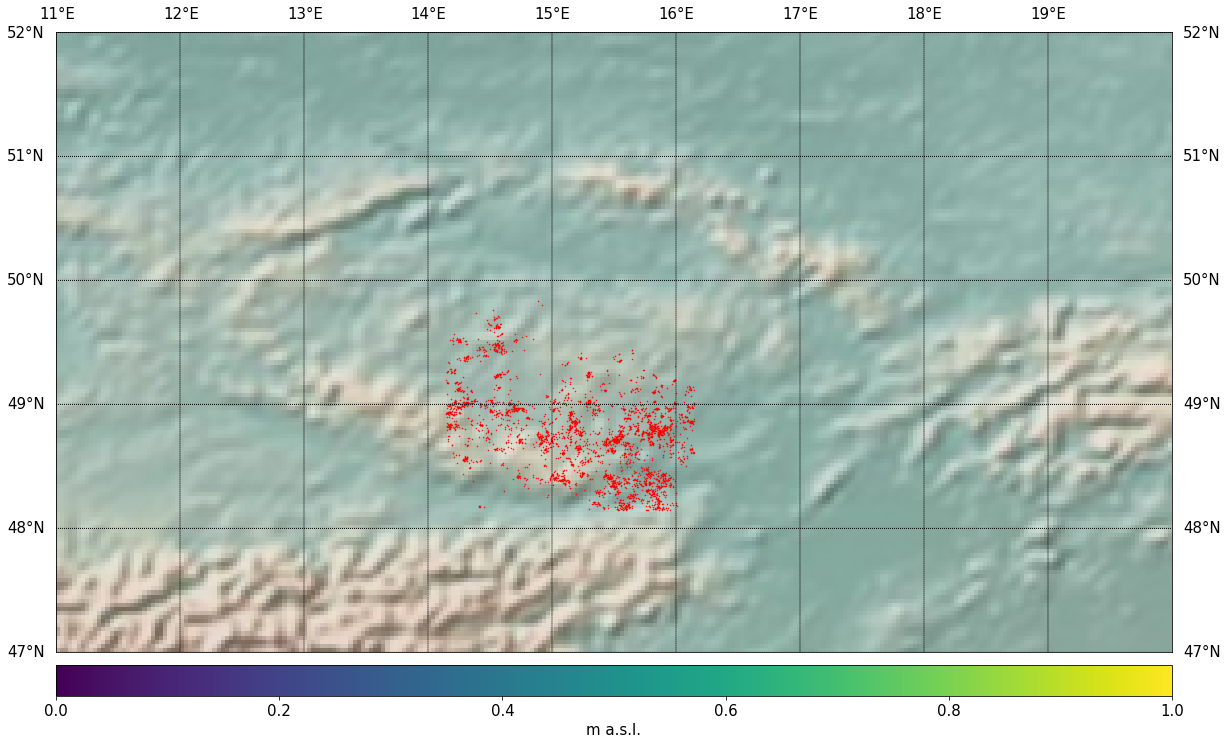

In [403]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(blitz.lon.tolist(),blitz.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
m.shadedrelief()

#im1 = m.scatter(x,y,c=blitz.date.tolist(),marker='+', cmap='jet')
im1 = m.scatter(x,y,c='red',marker='.', s=1, cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                
